## IMPORTANT LINKS
https://www.nltk.org/book/ch05.html


https://dr.ntu.edu.sg/bitstream/10356/62519/1/A_Grammar_of_Pnar-Hiram_Ring-PhD_Thesis-FINAL.pdf

In [20]:
from utils import *
import nltk
import matplotlib.pyplot as plt

## Load train and test data

First, load the train and test data using the same method in project 1. We also make sure that the test data does not repeat in the train data.

In [21]:
# Load data
train_data = load_data("datasets/full_text.txt", tags=["mb", "ps"])
original_length = len(train_data)
test_data = load_data("datasets/test.txt", tags=["mb", "ps"])

# Remove test data from train data
for data in test_data:
    train_data.remove(data)
assert(len(train_data) == original_length - len(test_data))

# Format data for taggers
train = format_data(train_data)
test = format_data(test_data)

## Exploratory Data Analysis

Before starting on tagging, explore the train data first and visualize some basic statistics. We plot the frequency of pos and mb individually below.

In [22]:
len(train)

5895

Unique pos tags: 50


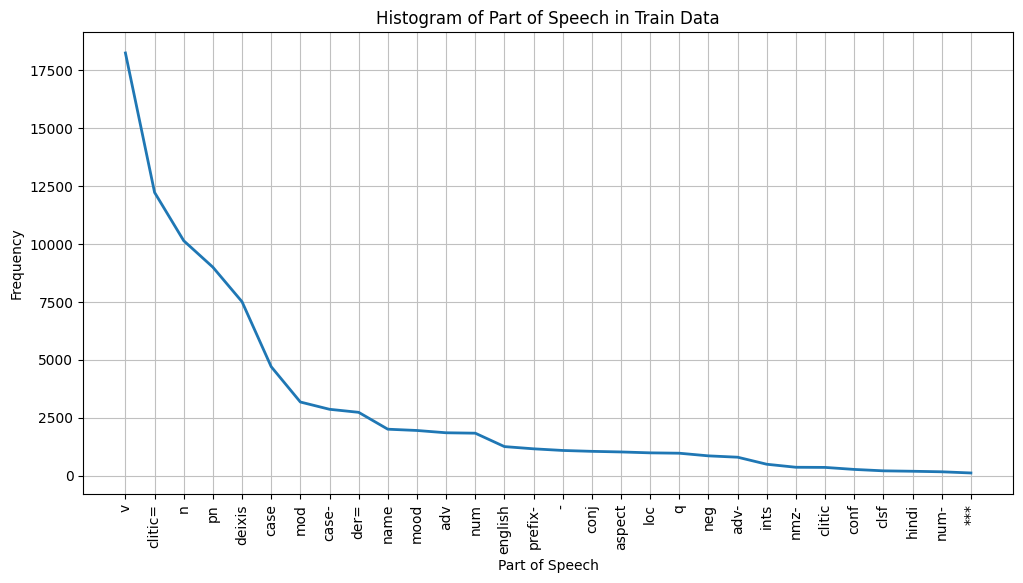

In [30]:
# Extract all POS tags from the training data
pos_tags = [tag for line in train for _, tag in line]

# Create a frequency distribution of the POS tags
freq_dist = nltk.FreqDist(pos_tags)
print("Unique pos tags:", len(freq_dist.keys()))
# Plot the histogram
plt.figure(figsize=(12, 6))
freq_dist.plot(30, title="Histogram of Part of Speech in Train Data")
plt.xlabel('Part of Speech')
plt.ylabel('Frequency')
plt.show()

We observe that the highest frequency of pos is "v", followed by "clitic="

Unique Mbs:  2595


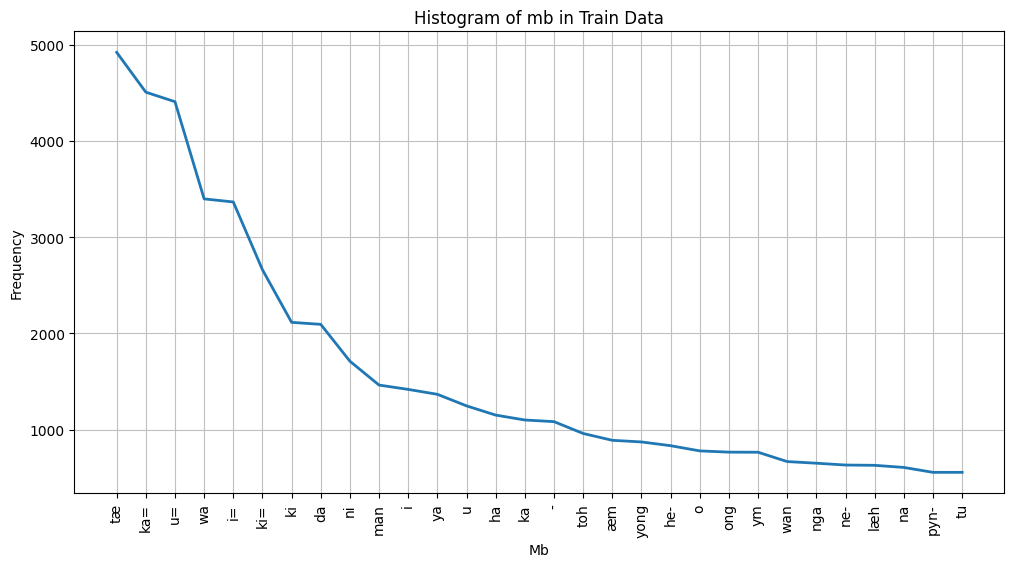

In [29]:
# Extract all words from the training data
words = [mb for line in train for mb, _ in line]

# Create a frequency distribution of the POS tags
freq_dist = nltk.FreqDist(words)
print("Unique Mbs: ", len(freq_dist.keys()))
# Plot the histogram
plt.figure(figsize=(12, 6))
freq_dist.plot(30, title="Histogram of mb in Train Data")
plt.xlabel('Mb')
plt.ylabel('Frequency')
plt.show()

We observe that "tae" occurs the most times, and that mb ending with "=" (e.g. ka=, u=, i=, ki=) occur very freqeuntly as well.

## Taggers

Here, we first define a utility function to print out all mb that were wrongly predicted by the tagger. This allows us to understand the type of words being wrongly tagged, as well as how often it happens

In [4]:
def print_wrong_tags(tagger, data, ljust=10):
    '''
    Function to print out all words that are wrongly predicted by the tagger
    '''
    # Initialize empty dictionary to store counts
    freq_dict = {}
    
    # Iterate through each sentence in the data
    for sent in data:
        # Get tagger's prediction for the sentence
        pred_sent = tagger.tag([mb for mb, _ in sent])

        # Iterate through each item in the prediction and ground truth
        for pred, actual in zip(pred_sent, sent):
            # Check if prediction is wrong
            if pred != actual:
                # Add add the mb to the dictionary if its wrong
                t = (pred[0], pred[1], actual[1])
                if t in freq_dict:
                    freq_dict[t] = freq_dict[t] + 1
                else:
                    freq_dict[t] = 1

    # Sort the dictionary in descending order of wrong counts
    sorted_freq_dict = dict(sorted(freq_dict.items(), reverse=True, key=lambda item: item[1]))

    # Print the dictionary in a pretty format
    print("mb".ljust(ljust), "|", "predicted".ljust(ljust), "actual".ljust(ljust), "|", "count")
    print("-"*ljust*5)
    for key in sorted_freq_dict.keys():
        print(key[0].ljust(ljust),"|", str(key[1]).ljust(ljust), str(key[2]).ljust(ljust), "|", str(sorted_freq_dict[key]))


### Effect of data volume on performance

The first experiment was to observe how the volume of training data affects tagging performance. Using the unigram tagger as the baseline, we incrementally add more training data and observe how the accuracy on the test data is affected.

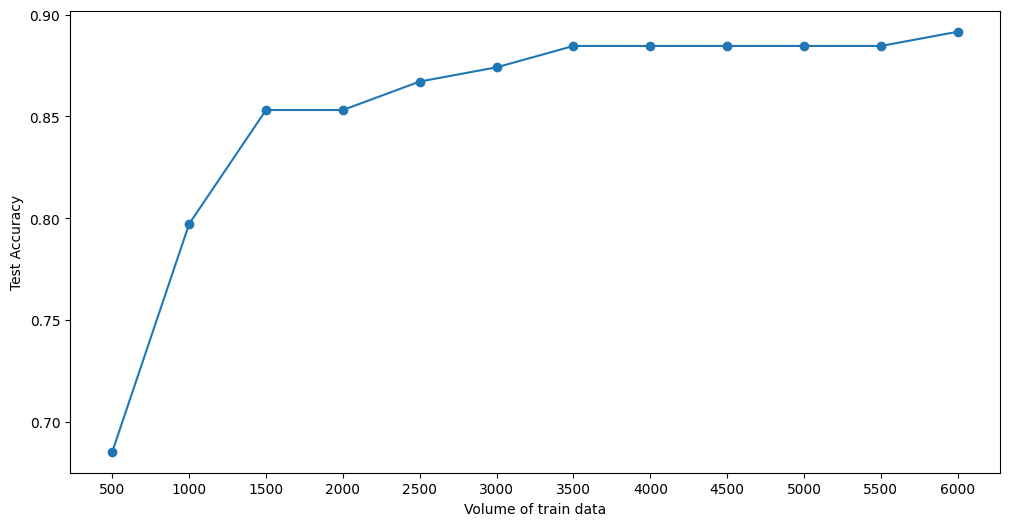

In [5]:
test_scores = [] # Initialize empty list to store accuracy scores
index_subsets = [i+500 for i in range(0, len(train), 500)] # Create list of volume of train data to use

# Train and evaluate unigram tagger on each split of train data
for index in index_subsets:
    unigram_tagger = nltk.UnigramTagger(train[:index]) 
    test_scores.append(unigram_tagger.accuracy(test))

# Plot the test accuracies
plt.figure(figsize=(12, 6))
plt.plot(index_subsets, test_scores, marker='o')
plt.xlabel('Volume of train data')
plt.ylabel('Test Accuracy')
plt.xticks(index_subsets)
plt.show()

From the plot above, we observe that the volume of data greatly improves accuracy at smaller amounts, but plateus around 3500 sentences. We also observe that just by having large amounts of data, our baseline model is able to achieve ~89% accuracy which is pretty good.

### Individual n-gram taggers

Next, we study how changing the n in n-grams affect the taggers. We observe that as n increases, the n-gram tagger accuracy decreases. This is because when n increases, n-grams become longer and the tagger is more likely to have never seen the n-gram before. Hence causing the tagger to label it as "None".

In [6]:
unigram_tagger = nltk.UnigramTagger(train)
print("Unigram tagger accuracy: ", unigram_tagger.accuracy(test))

bigram_tagger = nltk.BigramTagger(train)
print("Bigram tagger accuracy: ", bigram_tagger.accuracy(test))

trigram_tagger = nltk.TrigramTagger(train)
print("Trigram tagger accuracy: ", trigram_tagger.accuracy(test))

Unigram tagger accuracy:  0.8916083916083916
Bigram tagger accuracy:  0.4160839160839161
Trigram tagger accuracy:  0.2762237762237762


### Default tagger

In [7]:
print_wrong_tags(unigram_tagger, test)

mb         | predicted  actual     | count
--------------------------------------------------
u=         | clitic=    der=       | 9
ki=        | clitic=    der=       | 4
riot       | None       n          | 3
wa         | mod        conj       | 2
læh        | adv        v          | 2
i=         | clitic=    der=       | 1
land       | None       english    | 1
holding    | None       english    | 1
revision   | None       english    | 1
phorward   | None       english    | 1
issue      | None       english    | 1
rebenu     | None       english    | 1
bait       | adv        v          | 1
sud        | None       v          | 1
jooh       | aspect     v          | 1
ka=        | clitic=    der=       | 1


We observe that majority of unseen words (labelled as None) have true labels 'english'.

Solution: Create a default tagger to tag unseen words with the 'english' pos

In [8]:
default_tagger = nltk.DefaultTagger("english")
print("Default tagger accuracy: ", default_tagger.accuracy(test))

unigram_tagger = nltk.UnigramTagger(train, backoff=default_tagger)
print("Unigram + Default backoff accuracy: ",unigram_tagger.accuracy(test))

Default tagger accuracy:  0.05244755244755245
Unigram + Default backoff accuracy:  0.9125874125874126


This increases the accuracy by ~3%

## Ensemble Taggers

In [9]:
bigram_tagger = nltk.BigramTagger(train, backoff=unigram_tagger)
print("Bigram backoff accuracy: ", bigram_tagger.accuracy(test))

Bigram backoff accuracy:  0.9195804195804196


In [10]:
trigram_tagger = nltk.TrigramTagger(train, backoff=bigram_tagger)
print("Trigram backoff accuracy: ",trigram_tagger.accuracy(test))

Trigram backoff accuracy:  0.9195804195804196


We observe that integrating bigram tagger into the ensemble only improves accuracy marginall (~0.7%)

Integrating trigram tagger does not have any impact on the accuracy at all

## Further analysis

In [11]:
print_wrong_tags(unigram_tagger, train)

mb         | predicted  actual     | count
--------------------------------------------------
u=         | clitic=    der=       | 1919
ka=        | clitic=    der=       | 492
da         | mood       case       | 281
wa         | mod        conj       | 230
i=         | clitic=    der=       | 195
ki=        | clitic=    der=       | 121
læh        | adv        v          | 119
dooh       | loc        v          | 98
jooh       | aspect     v          | 83
dooh       | loc        adv        | 68
bhah       | v          n          | 68
biang      | v          adv        | 54
bha        | adv        v          | 43
daw        | n          mood       | 43
bait       | adv        v          | 40
pa         | conj       n          | 33
æh         | adv        v          | 31
hæh        | v          adv        | 24
chah       | aspect     v          | 21
yong       | case       v          | 16
khoh       | n          v          | 15
khmat      | loc        n          | 12
tang       | conj 

Looking at the wrongly predicted pos in the train data, we see that majority of the errors come from mb that end with "=". This includes "u=", "ki=", "ka=", and "i=". This is because majority of the time, these mb are labelled as "clitic=", but there are some cases where they should be labelled as "der=" instead.

One drawback of nltk's n-gram tagger is that they only search backwards. I.e. they do not look at words in front. Additionally, they only perform a single level of search and are unable to check pos of previous words.

Using the interlinear search function in project1, we observe that "u=", "ki=", "ka=", and "i=" are more likely to have pos "der=" when the pos after it is "v".

Solution: we create a custom bigram tagger that labels "ki=", "ka=", "i=" with pos "der=" if the following pos is "v"

In [12]:
class CustomBigramTagger(nltk.BigramTagger):
    def tag(self, tokens):
        # First use BigramTagger's default tagging
        tagged_tokens = super().tag(tokens)
        
        # Iterate through the tagged tokens
        for i in range(len(tagged_tokens) - 1):
            word, pos = tagged_tokens[i]
            next_word, next_pos = tagged_tokens[i + 1]
            
            # Replace the pos tag with "der=" if the next pos is "v"
            if word == "u=" and next_pos == "v":
                tagged_tokens[i] = (word, "der=")
            elif word == "ki=" and next_pos == "v":
                tagged_tokens[i] = (word, "der=")
            elif word == "ka=" and next_pos == "v":
                tagged_tokens[i] = (word, "der=")
            elif word == "i=" and next_pos == "v":
                tagged_tokens[i] = (word, "der=") 
        
        return tagged_tokens

In [13]:
custom_tagger = CustomBigramTagger(train, backoff=unigram_tagger)
print("Custom tagger accuracy: ",custom_tagger.accuracy(test))

Custom tagger accuracy:  0.9475524475524476


This solution increases our accuracy by ~2.7% which is great.

In [14]:
print_wrong_tags(custom_tagger, train)

mb         | predicted  actual     | count
--------------------------------------------------
u=         | der=       clitic=    | 450
i=         | der=       clitic=    | 315
da         | mood       case       | 267
wa         | mod        conj       | 229
u=         | clitic=    der=       | 166
bhah       | v          n          | 47
læh        | adv        v          | 29
ka=        | clitic=    der=       | 18
bait       | adv        v          | 18
hæh        | v          adv        | 16
i=         | clitic=    der=       | 15
dooh       | adv        v          | 12
dooh       | v          adv        | 12
bhah       | n          v          | 11
læh        | v          adv        | 10
æh         | adv        v          | 9
bha        | adv        v          | 9
ka=        | der=       clitic=    | 8
biang      | adv        v          | 8
jooh       | aspect     v          | 7
doh        | n          name       | 7
san        | num        v          | 7
da         | case       mood

Now we observe that there are now some instances of "u=" and "i=" wrongly labelled as "der=" when they are actually "clitic=". Further analysis can be done to determine how to label them.


## Results

In [15]:
baseline = nltk.UnigramTagger(train)
default = nltk.UnigramTagger(train, backoff=nltk.DefaultTagger("english"))
bigram = nltk.BigramTagger(train, backoff=default)
custom = CustomBigramTagger(train, backoff=default)

train_scores, test_scores = [], []
for tagger in [baseline, default, bigram, custom]:
    train_scores.append(tagger.accuracy(train))
    test_scores.append(tagger.accuracy(test))

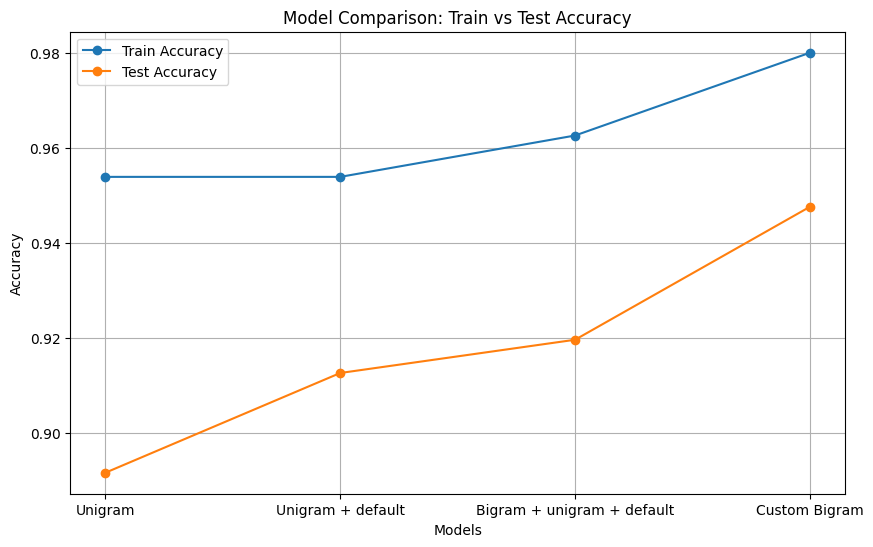

In [16]:
model_names = ['Unigram', 'Unigram + default', 'Bigram + unigram + default', 'Custom Bigram']

# Create the plot
plt.figure(figsize=(10, 6))

# Plot train scores and test scores
plt.plot(model_names, train_scores, label='Train Accuracy', marker='o')
plt.plot(model_names, test_scores, label='Test Accuracy', marker='o')

# Add title and labels
plt.title('Model Comparison: Train vs Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

Overall, our efforts in this project was able to improve the test accuracy score from the baseline by ~5%